<a href="https://colab.research.google.com/github/doublea1186/CIS522/blob/main/Fine_tuning_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
#@title Imports and installs
!pip install transformers

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as alb
from tqdm.autonotebook import tqdm, trange
import itertools
import seaborn as sns
from numpy import savetxt, loadtxt
import torchvision.models as models
from google.colab import files

In [ ]:
#@title Download dataset (takes 20 minutes)

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations
! unzip -q h-and-m-personalized-fashion-recommendations.zip -d .

In [ ]:
#@title Data configs
class Config:
  base = '' # change to whereever the data is stored
  debug = False

  # we want batch size to be as big as possible for contrastive loss
  # OpenAI uses 32768 but we can only use 128 due to RAM constraints 
  batch_size = 128

  num_workers = 2
  head_lr = 1e-3
  image_encoder_lr = 1e-4
  text_encoder_lr = 1e-5

  # weight decay is .2 in CLIP Paper
  weight_decay = 0.2

  # we use a different LR, namely decrease on Plateau 
  # Decrease LR after 1 epoch with no improvement 
  patience = 1
  factor = 0.8

  # CLIP paper did 32 epochs
  # because of our compute we can only realistically do 10 epochs 
  # takes about 20 minutes per epoch using AWS EC2 p3.2xlarge instance
  # total runtime of about 4 hours to train the model 
  epochs = 8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  model_name = 'resnet50'
  image_embedding = 2048
  base_image_embedding = 64
  resnet18_embed = 512

  # original text encoder was transformer
  text_encoder_model = "distilbert-base-uncased"
  text_embedding = 768
  base_text_embedding = 300
  text_tokenizer = "distilbert-base-uncased"
  max_length = 50

  pretrained = True # for both image encoder and text encoder
  trainable = True # for both image encoder and text encoder
  temperature = 1.0

  # CLIP used 224, have to use 112 for computational advantages
  image_size = 112

  # for projection head; used for both image and text encoders
  num_projection_layers = 1
  projection_dim = 256 
  dropout = 0.3

## Loading and Feature Engineering Text Data for Clothing

In [ ]:
articles = pd.read_csv(Config.base + 'articles.csv')
articles = articles.set_index(['article_id'])
articles.loc[articles.index == 108775015, 'detail_desc']

article_id
108775015    Jersey top with narrow shoulder straps.
Name: detail_desc, dtype: object

In [ ]:
#Extract natural language columns
articles_nlp = articles[['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']]

In [ ]:
index_group_to_nlp = {'Ladieswear':"women", 'Baby/Children':'children', 'Menswear':'men', 'Sport':'sport', 'Divided':'all genders'}

In [ ]:
articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])

In [ ]:
desc_format = "A picture of a {0}, a {12} It is a {1}, which is a {2} for {9}. It is {6} with a {5} pattern."
articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]

In [ ]:
articles_nlp["long_description"][108775015]

'A picture of a Strap top, a Jersey top with narrow shoulder straps. It is a Vest top, which is a Garment Upper body for women. It is Black with a Dark pattern.'

In [ ]:
articles["long_description"] = articles_nlp["long_description"]

# Fine Tuning OpenAI CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip
import time

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
  def __init__(self, root, preprocess):
    self.images, self.captions = make_dataset(root)
    self.preprocess = preprocess

  def __getitem__(self, index):
    img = self.images[index]
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.preprocess(Image.fromarray(img.astype(np.uint8)))

    return (img, self.captions[index])

  def __len__(self):
    return len(self.images)

In [ ]:
device = Config.device
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) # Must set jit=False for training

dataset = CLIPDataset('/content/images/', preprocess)

train_size = int(0.9 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

print(f'train size: {train_size} val size: {val_size} test size: {test_size}')

# split full dataset into a training/val/test set with an 90/10/10 split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 104MiB/s]


train size: 94590 val size: 5255 test size: 5255


In [ ]:
print(model)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

## Training

In [ ]:
# freeze transformer layers
ct = 0
for child in model.children():
  ct += 1
  if ct < 3:
    for param in child.parameters():
      param.requires_grad = False

In [ ]:
num_epochs = 2
batches = len(train_loader)

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# params from paper, lr, weight decay is smaller
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=1e-4, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.001)
# lowers the learning rate to its minimum in each epoch and then restart from the base learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=batches, eta_min=1e-6)

running_loss = []
training_losses = []
val_losses = []
val_epoch = []
train_epoch = []

for epoch in range(num_epochs):
  with tqdm(total=batches, desc='train_loss: ', leave=True) as progress_bar:
    for img_list, txt_list in train_loader:
      optimizer.zero_grad()
    
      images = img_list.to(device)
      texts = clip.tokenize(txt_list, truncate=True).to(device)
    
      logits_per_image, logits_per_text = model(images, texts)

      ground_truth = torch.arange(images.shape[0], dtype=torch.long, device=device)

      avg_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2
      avg_loss.backward()

      optimizer.step()
      scheduler.step()

      training_losses += [avg_loss.item()]
      running_loss += [avg_loss.item()]

      progress_bar.update(1)
      progress_bar.set_description("train_loss: {:.6f}".format(training_losses[-1]))
      progress_bar.refresh()
      time.sleep(0.01)
    
  train_epoch.append(sum(running_loss) / len(running_loss))
  running_loss = []

  # EVAL
  model.eval()
  with tqdm(total=len(val_loader), desc='val_loss: ', leave=True) as progress_bar:
    for img_list, txt_list in val_loader:
      with torch.no_grad():
        images = img_list.to(device)
        texts = clip.tokenize(txt_list, truncate=True).to(device)

        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(images.shape[0], dtype=torch.long, device=device)

        avg_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2
        val_losses += [avg_loss.item()]
        running_loss += [avg_loss.item()]

        # update progress bar
        progress_bar.update(1)
        progress_bar.set_description("val_loss: {:.6f}".format(val_losses[-1]))
        progress_bar.refresh()
        time.sleep(0.01)
    val_epoch.append(sum(running_loss) / len(running_loss))
  
  save_model(epoch + 1)

train_loss:   0%|          | 0/739 [00:00<?, ?it/s]

val_loss:   0%|          | 0/42 [00:00<?, ?it/s]

train_loss:   0%|          | 0/739 [00:00<?, ?it/s]

val_loss:   0%|          | 0/42 [00:00<?, ?it/s]

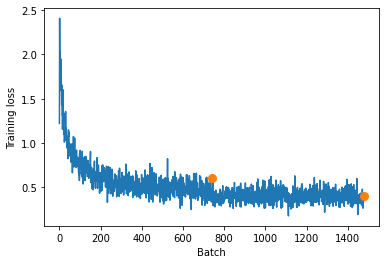

In [ ]:
plt.plot(training_losses)
plt.plot(batches, train_epoch[0], c='tab:orange', marker='o', markersize=8)
plt.plot(batches*2, train_epoch[1], c='tab:orange', marker='o', markersize=8)
plt.xlabel('Batch')
plt.ylabel('Training loss')
plt.show()

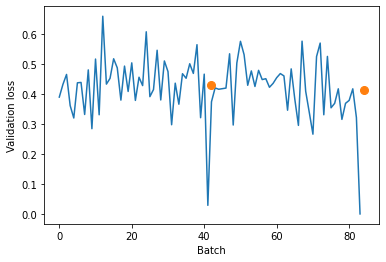

In [ ]:
plt.plot(val_losses)
plt.plot(len(val_loader), val_epoch[0], c='tab:orange', marker='o', markersize=8)
plt.plot(len(val_loader)*2, val_epoch[1], c='tab:orange', marker='o', markersize=8)
plt.xlabel('Batch')
plt.ylabel('Validation loss')
plt.show()

In [ ]:
savetxt('train_losses.csv', training_losses, delimiter=',')
savetxt('val_losses.csv', val_losses, delimiter=',')
!cp train_losses.csv '/content/drive/MyDrive/project/'

In [ ]:
!cp model_1.pt '/content/drive/MyDrive/project/'

## Evaluation

In [ ]:
import random

def sample_random(items, num):
  return random.sample(items, num)

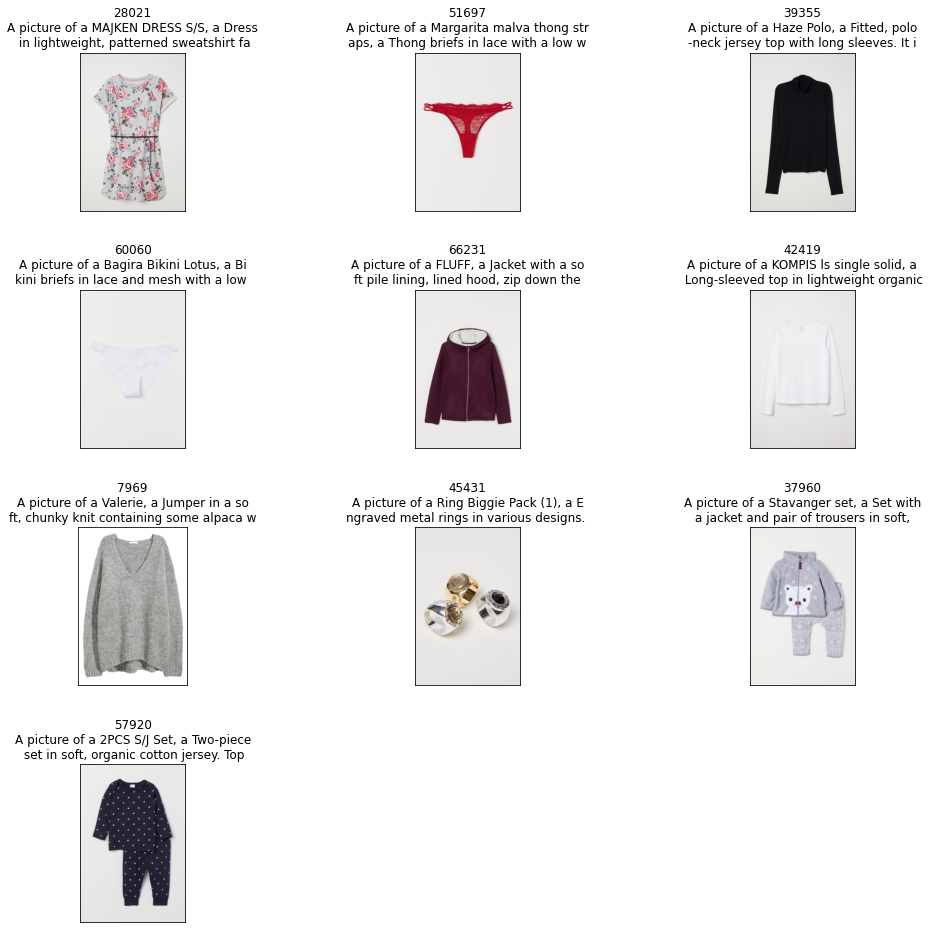

In [ ]:
random_test_imgs = sample_random(test_dataset.indices, 10)
plt.figure(figsize=(16, 16))

for i, idx in enumerate(random_test_imgs):
  plt.subplot(4, 3, i + 1)
  img = Image.open(test_dataset.dataset.images[idx])
  plt.imshow(img)

  plt.title(f"{idx}\n{test_dataset.dataset.captions[idx][:40]}\n{test_dataset.dataset.captions[idx][40:80]}")
  plt.xticks([])
  plt.yticks([])

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp '/content/drive/MyDrive/project/model_1.pt' '/content/'

In [ ]:
model = load_model(model, 'model_1.pt')

In [ ]:
def get_accuracy(model, dataloader):
  total_correct = 0
  total = 0
  running_accuracy = []

  model.eval()
  for images, captions in tqdm(dataloader):
    with torch.no_grad():
      image_input = images.to(device)
      image_features = model.encode_image(image_input).float()
      text_tokens = clip.tokenize(captions, truncate=True).to(device)
      text_features = model.encode_text(text_tokens).float()
      
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
      
      indices = np.argmax(similarity, axis=0)
      total += len(images)
      ground_truth = np.arange(len(images), dtype=int)
      correct = len(images) - np.count_nonzero(ground_truth - indices)
      total_correct += correct

      running_accuracy += [100*correct/len(images)]
  
  return 100*total_correct/total, running_accuracy

  0%|          | 0/42 [00:00<?, ?it/s]

Average accuracy: 88.82968601332065


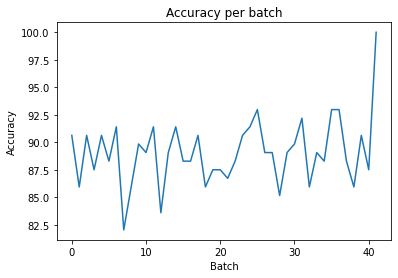

In [ ]:
avg_accuracy, acc_per_batch = get_accuracy(model, test_loader)
print(f'Average accuracy: {avg_accuracy}')
plt.plot(acc_per_batch)
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy per batch')
plt.show()

### Test queries

In [ ]:
def get_image_embeddings(data, model):
  embeddings = []
  model.eval()

  with torch.no_grad():
    for images, captions in tqdm(data):
      image_features = model.encode_image(images.to(Config.device)).float()
      image_features /= image_features.norm(dim=-1, keepdim=True)
      embeddings.append(image_features)
  
  return torch.cat(embeddings)

In [ ]:
def find_matches(model, dataset, queries):
  # get image embeddings
  embeddings = []
  model.eval()

  with torch.no_grad():
    for i in range(0, len(dataset.indices), Config.batch_size):
      indices = dataset.indices[i:i + Config.batch_size]
      images = [dataset.dataset[i][0] for i in indices]
      img_input = torch.tensor(np.stack(images)).to(Config.device)
      image_features = model.encode_image(img_input).float()
      
      embeddings.append(image_features)

    image_features = torch.cat(embeddings)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # get query text embeddings
    text_tokens = clip.tokenize(queries).cuda()
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
  
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
  indices = np.argmax(similarity, axis=1)
  matches = [test_dataset.dataset.images[test_dataset.indices[idx]] for idx in indices]
  return matches

(10, 5255)


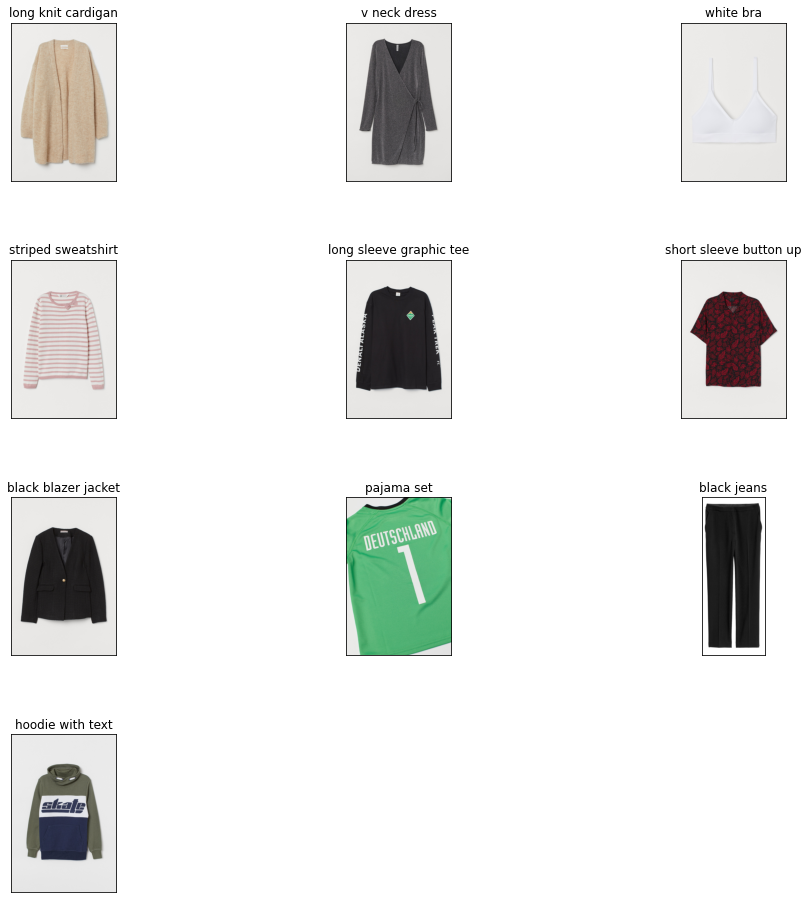

In [ ]:
queries = ['long knit cardigan', 'v neck dress', 'white bra', 'striped sweatshirt', 
           'long sleeve graphic tee', 'short sleeve button up','black blazer jacket', 
           'pajama set', 'black jeans', 'hoodie with text']
matches = find_matches(model, test_dataset, queries)

plt.figure(figsize=(16, 16))
for i in range(len(queries)):
  img = Image.open(matches[i])
  plt.subplot(4, 3, i + 1)
  plt.imshow(img)
  plt.title(f'{queries[i]}')
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)

plt.show()